# User Based Filtering with Similarity
---

모델 기반으로 평점을 예측할 때, cold start 문제에 대해 정확도가 낮음을 확인했다.

이를 개선하기 위해 user 기반으로 유사도를 측정해 평점을 예측해보고자 한다.

카디널리티를 조정하지 않은 데이터를 사용해서 측정한다.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load & Shape
books = pd.read_csv('data/books_1.0.csv')
users = pd.read_csv('data/users_f_location_1.1.csv')

ratings = pd.read_csv('data/train_ratings.csv')

# user 데이터 전처리

### user `age` 카테고리화

In [3]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

In [4]:
users.age = users.age.fillna(users.age.mean())
users.age = users.age.apply(age_map)

`location` 변수 null 값 대치

In [5]:
users = users.fillna('other')

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

for col in ['location_city','location_state','location_country']:
    le = LabelEncoder()
    users[col] = le.fit_transform(users[col])
    
users

,user_id,age,location_city,location_state,location_country
0,8,3,10628,800,46
1,11400,4,7912,800,46
2,67544,3,10686,800,46
3,85526,3,11061,163,46
4,96054,2,7912,800,46
...,...,...,...,...,...
68087,156948,3,7907,812,179
68088,169489,3,7907,812,179
68089,56072,3,7907,812,179
68090,64582,3,7907,812,179


## 유저 클러스터링

elbow method로 최적의 클러스터 개수 찾기

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline 

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(users.drop('user_id', axis=1)) # user_id를 넣으면 군집이 user_id에 종속됨
    distortions.append(kmeanModel.inertia_)
    


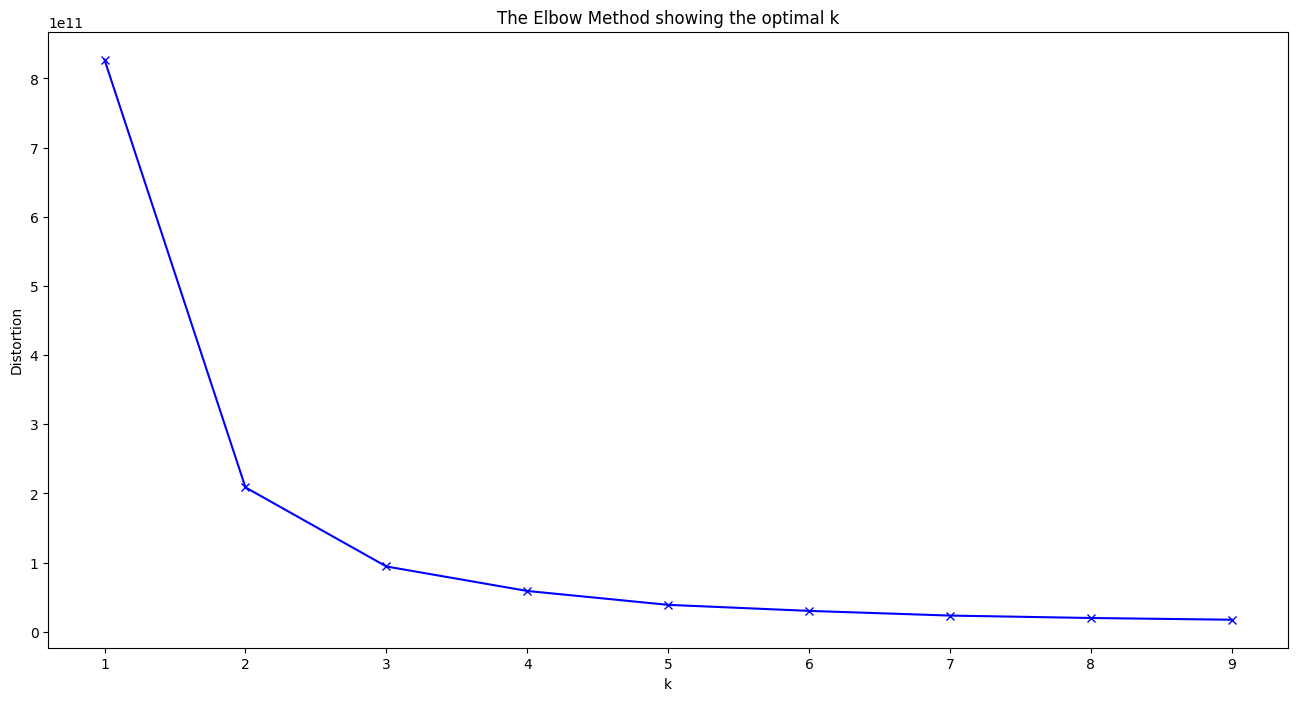

In [9]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [10]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit_predict(users.drop('user_id', axis=1))


array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score

score = silhouette_score(users.drop('user_id', axis=1), kmeans.labels_, metric='cosine')
print(score)

cosine: 0.02931663270172172  
jaccard: -0.332741002660775  

=> 각 군집별로 실루엣 점수를 계산한 결과 Cosine으로 유사도를 계산하는 것이 더 적합하다

In [13]:
users['label'] = kmeans.labels_

# user의 유사도 구하기

In [14]:
zero_uid = users.query('label==0')['user_id'].values
one_uid = users.query('label==1')['user_id'].values
                       
users = users.drop('user_id', axis=1)
zero = users.query('label == 0').drop('label', axis=1)
one = users.query('label == 1').drop('label', axis=1)

In [15]:
zero

,age,location_city,location_state,location_country
6,3,5360,800,46
8,3,2307,800,46
9,3,4229,800,46
10,6,4301,777,46
11,2,3666,716,46
...,...,...,...,...
68074,1,5696,358,245
68076,3,1533,800,46
68078,5,2609,184,245
68080,3,4981,21,245


코사인 유사도를 계산하기 위해 각 변수를 임베딩

In [16]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
zero_vec = vec.fit_transform(zero.T.to_dict().values())

one_vec = vec.fit_transform(one.T.to_dict().values())

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
zero_cosine = cosine_similarity(zero_vec)
one_cosine = cosine_similarity(one_vec)

In [18]:
print(zero_cosine.shape)
print(one_cosine.shape)
print(len(zero_uid))
print(len(one_uid))


(30231, 30231)
(37861, 37861)
30231
37861


36003  
49713

adding bias?

In [21]:
cold_id = ratings.user_id.value_counts().where(ratings.user_id.value_counts() == 1).dropna().index
warm_id = ratings.user_id.value_counts().where(ratings.user_id.value_counts() == 5).dropna().index

In [59]:
import random
from tqdm import tqdm
THRESHOLD = 0.7
pred = []
actu = []
uid_rec = []
for ra in tqdm(cold_id):
    if ra in zero_uid:
        result = UBCF(zero_uid, zero_cosine, ra)
        l = result.user_id.values
    else:
        result = UBCF(one_uid, one_cosine, ra)
        l = result.user_id.values


    isbn_1 = ratings.query('user_id == @ra').isbn.values[0]
    a = ratings.query('user_id in @l and isbn == @isbn_1').query('user_id != @ra')
    if len(a) == 0:
        continue
    
    b = 0
    actual = ratings.query('user_id == @ra').rating.values[0]
    for uid, r in a[['user_id', 'rating']].values:
        weight = result.query('user_id == @uid').similarity.values[0]
        b += r * weight

    uid_rec.append(ra)
    pred.append(b / len(a))
    actu.append(actual)


100%|██████████| 34617/34617 [43:42<00:00, 13.20it/s]  


In [66]:
import random
from tqdm import tqdm
THRESHOLD = 0.7
pred_ctow = []
actu_ctow = []
uid_rec_ctow = []
for ra in tqdm(ctow.user_id.values):
    if ra in zero_uid:
        result = UBCF(zero_uid, zero_cosine, ra)
        l = result.user_id.values
    else:
        result = UBCF(one_uid, one_cosine, ra)
        l = result.user_id.values


    isbn_1 = ratings.query('user_id == @ra').isbn.values[0]
    a = ratings.query('user_id in @l and isbn == @isbn_1').query('user_id != @ra')
    if len(a) == 0:
        continue
    
    b = 0
    actual = ratings.query('user_id == @ra').rating.values[0]
    for uid, r in a[['user_id', 'rating']].values:
        weight = result.query('user_id == @uid').similarity.values[0]
        b += r * weight

    uid_rec_ctow.append(ra)
    pred_ctow.append(b / len(a))
    actu_ctow.append(actual)


100%|██████████| 18081/18081 [26:47<00:00, 11.25it/s] 


In [61]:
print(len(actu))
uio = np.abs(np.subtract(actu, pred))
np.where(uio>9)

(array([   34,    45,    97,   237,  1208,  2265,  2638,  3350,  3733,
         4774,  4920,  5356,  5500,  5576,  6002,  6212,  6328,  6342,
         8066, 11819, 15568, 15712, 17950, 18160, 18232, 20122, 21756]),)

전체 평점에 대한 rmse

In [46]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(actu, pred)**0.5
print(RMSE)

2.6549281992605014


In [67]:
print(len(actu_ctow))
uio_ctow = np.abs(np.subtract(actu_ctow, pred_ctow))
np.where(uio_ctow>9)

17936


(array([13948]),)

평점을 한번도 내리지 않은 유저가(cold-user) 평가가 많은 아이템(warm-item)에 대한 평점에 대한 rmse

In [ ]:
from sklearn.metrics import mean_squared_error

RMSE_ctow = mean_squared_error(actu_ctow, pred_ctow)**0.5
print(RMSE_ctow)

2.4782892334279887


## 결론
cold user에 대해 fm 모델의 rmse는 2.3이었다.

user 유사도 기반 예측의 rmse는 2.4가 나왔으므로 이는 사용할 수 없다고 판단했다.